# Example for Autoencoding

this notebook trains a CAE (convolutional autoencoder) for image reconstruction.
Used for this work is the MVTec Anomaly Detection Dataset.

The specific case are transistors, but any anomaly detection dataset can be used.

In [50]:
import os
import glob

import sys

sys.path.append('../.')

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from nerovision.nv_enums import ImageFormat
from nerovision.dl.auto_encoding.data.FilepathAEDataset import FilepathAEDataset
from nerovision.dl.auto_encoding.training import AETrainer
from nerovision.dl.auto_encoding.models.CAE import CAE
from nerovision.dl.callbacks.Checkpointer import Checkpointer
from nerovision.dl.callbacks.CSVLogger import CSVLogger

## 1.0 Train CAE

the first step is to train an autoencoder for getting started using it for tasks like anomaly detection.

### 1.1 Setup Data loading

the very first step in training an autoencoder is to prepare the data.
Remember, we need two sets of data for this case:

- good - so, non-anomalous data - that is being used as training and validation data to train the network
- anomalous, this data is being used to check whether the Autoencoder is working properly

when training such an encoder somebody should always make visual verification, meaning whether things are reconstructed properly or poorly (when we expect it)

I assume the user (so you) has been training a neural network with PyTorch already, if not I would recommend doing that.
Below are some transformations being used to train our Autoencoder

In [2]:
def get_transformations(im_h: int, im_w: int, image_format: ImageFormat):
    if image_format == ImageFormat.rgb:
        normalize = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    elif image_format == ImageFormat.gray_16 or image_format == ImageFormat.gray_8:
        normalize = A.Normalize(mean=0.5, std=0.5)
    else:
        raise ValueError('Unsupported image format: {}'.format(image_format))

    t_train = A.Compose(
        [
            # A.SmallestMaxSize(max_size=160),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.2),
            A.RandomCrop(height=im_h * 2, width=im_w * 2, p=0.2),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),
            A.RandomBrightnessContrast(p=0.2),
            A.HorizontalFlip(p=0.2),
            A.Affine(p=0.2, scale=0.8, shear=5, translate_percent=0.1, rotate=20),
            A.Blur(blur_limit=3, p=0.1),
            A.OpticalDistortion(p=0.1),
            A.GridDistortion(p=0.1),
            A.HueSaturationValue(p=0.1),
            A.Resize(height=im_h, width=im_w, p=1),
            normalize,
            ToTensorV2(),
        ]
    )
    t_val = A.Compose(
        [
            A.Resize(height=im_h, width=im_w, p=1),
            normalize,
            ToTensorV2(),
        ]
    )
    return t_train, t_val

In [3]:
def create_loaders(
        dataset_path: str,
        im_h: int,
        im_w: int,
        im_format: ImageFormat,
        val_size: float = 0.2,
):
    train_transform, val_transform = get_transformations(im_h, im_w, im_format)
    im_paths = glob.glob(os.path.join(dataset_path, '**/**.png'), recursive=True)
    n = int(len(im_paths) * (1 - val_size))
    train_paths = im_paths[:n]
    val_paths = im_paths[n:]

    train_dataset = FilepathAEDataset(filepaths=train_paths, transformations=train_transform, im_format=im_format)
    val_dataset = FilepathAEDataset(filepaths=val_paths, transformations=val_transform, im_format=im_format)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=1, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=1, persistent_workers=True)
    return train_loader, val_loader

below we set up the data loaders with some predefined Dataset classes implemented in PyTorch.
The dataset class is being implemented in this repo and simply takes a list of image paths and transformations and runs them, plus also reloading each image every time it is needed in case hardware is a limited ressource.

In [4]:
im_h = 224
im_w = 224
# create data loaders
data_root_path = r'C:\dev\autoencoding\data\transistor'
dataset_path = os.path.join(data_root_path, 'train')
model_path = os.path.join(data_root_path, 'model.onnx')
csv_log_path = os.path.join(data_root_path, 'logs.csv')
train_loader, val_loader = create_loaders(
    dataset_path,
    im_h=im_h,
    im_w=im_w,
    im_format=ImageFormat.rgb,
)

c:\Users\steph\anaconda3\envs\minetaur\lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## 1.2 Train model

below are the hyperparameters for the model itself, there are way more but others like learning rate or which optimizer to use but those are not specific to Autoencoders which is why they are not being taken care of here.

- features, the CAE has convolutional blocks (similar to a U-Net, without the encoder decoder connections), those resemble the number of features for each downscaling block during the encoding and decoding process. Because this CAE is symmetric, the encoder and decoder features are the same (just reverted in it's sequence)
- latent_dim, probably the most important hyperparameter to set. Designing a meaningfully latent space is absolute key to produce a reasonable Autoencoder. The latent space is the smallest representation during the network it has, this means it should be set wisely
- image size, (height, width) this should be set with domain expertise, so on whatever samples somebody is working on.

In [5]:
features = [32, 64, 128, 256]
latent_dim = 1024

TODO add optimizer
TODO add learning rate
TODO add proper Loss Implementation

below is not the creation of the model, trainer, callbacks and then the execution of the training loop.

Keep in mind that the callbacks follow the logic of PyTorch lightning and allow us to add custom logic into the training loop, here the logic for an onnx export and .csv logger is being added

In [12]:
ae = CAE(features=features, im_h=im_h, im_w=im_w, latent_dim=latent_dim)
trainer = AETrainer(ae)
callbacks = [
    Checkpointer(model_path, im_h, im_w, 3),
    CSVLogger(csv_log_path),
]
trainer.train_model(
    epochs=200,
    train_loader=train_loader,
    val_loader=val_loader,
    callbacks=callbacks,
)


running epoch: 1 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:04<00:00, 10.50it/s, batch_loss=0.775]



finished epoch: 1, train_loss: 1.0969334840774536, val_loss: 0.8296165466308594

running epoch: 2 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.42it/s, batch_loss=0.769]



finished epoch: 2, train_loss: 0.9890155792236328, val_loss: 0.8030233383178711

running epoch: 3 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 33.50it/s, batch_loss=0.791]



finished epoch: 3, train_loss: 0.9257063865661621, val_loss: 0.8384373784065247

running epoch: 4 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 32.38it/s, batch_loss=0.7]  



finished epoch: 4, train_loss: 0.9013296961784363, val_loss: 0.7346153855323792

running epoch: 5 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 33.05it/s, batch_loss=0.694]



finished epoch: 5, train_loss: 0.9000259637832642, val_loss: 0.7289846539497375

running epoch: 6 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 31.78it/s, batch_loss=0.71] 



finished epoch: 6, train_loss: 0.8696785569190979, val_loss: 0.7407554984092712

running epoch: 7 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 32.20it/s, batch_loss=0.696]



finished epoch: 7, train_loss: 0.8479775786399841, val_loss: 0.706883430480957

running epoch: 8 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 31.42it/s, batch_loss=0.706]



finished epoch: 8, train_loss: 0.854937732219696, val_loss: 0.706581175327301

running epoch: 9 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 31.17it/s, batch_loss=0.71] 



finished epoch: 9, train_loss: 0.8264650106430054, val_loss: 0.707907497882843

running epoch: 10 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 31.60it/s, batch_loss=0.698]



finished epoch: 10, train_loss: 0.8498588800430298, val_loss: 0.6905059218406677

running epoch: 11 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 28.90it/s, batch_loss=0.695]



finished epoch: 11, train_loss: 0.8173354864120483, val_loss: 0.7087073922157288

running epoch: 12 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 28.94it/s, batch_loss=0.708]



finished epoch: 12, train_loss: 0.8048427104949951, val_loss: 0.7073531746864319

running epoch: 13 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 29.18it/s, batch_loss=0.67] 



finished epoch: 13, train_loss: 0.7987019419670105, val_loss: 0.6631231307983398

running epoch: 14 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 30.26it/s, batch_loss=0.647]



finished epoch: 14, train_loss: 0.7887000441551208, val_loss: 0.6490326523780823

running epoch: 15 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 28.46it/s, batch_loss=0.643]



finished epoch: 15, train_loss: 0.7898882627487183, val_loss: 0.6564300060272217

running epoch: 16 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 27.44it/s, batch_loss=0.653]



finished epoch: 16, train_loss: 0.7982853651046753, val_loss: 0.6527578234672546

running epoch: 17 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 27.40it/s, batch_loss=0.678]



finished epoch: 17, train_loss: 0.8080331087112427, val_loss: 0.6937347054481506

running epoch: 18 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 28.20it/s, batch_loss=0.662]



finished epoch: 18, train_loss: 0.7817623615264893, val_loss: 0.6587849259376526

running epoch: 19 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 26.78it/s, batch_loss=0.634]



finished epoch: 19, train_loss: 0.7556333541870117, val_loss: 0.6353455781936646

running epoch: 20 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 26.74it/s, batch_loss=0.675]



finished epoch: 20, train_loss: 0.7980824112892151, val_loss: 0.6741582751274109

running epoch: 21 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 28.00it/s, batch_loss=0.651]



finished epoch: 21, train_loss: 0.7433438301086426, val_loss: 0.6481407284736633

running epoch: 22 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 21.16it/s, batch_loss=0.697]



finished epoch: 22, train_loss: 0.759253203868866, val_loss: 0.6738988161087036

running epoch: 23 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 24.98it/s, batch_loss=0.625]



finished epoch: 23, train_loss: 0.768968939781189, val_loss: 0.6370373368263245

running epoch: 24 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 24.00it/s, batch_loss=0.635]



finished epoch: 24, train_loss: 0.7857257723808289, val_loss: 0.6441658139228821

running epoch: 25 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 23.20it/s, batch_loss=0.617]



finished epoch: 25, train_loss: 0.7682642340660095, val_loss: 0.6333274245262146

running epoch: 26 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.18it/s, batch_loss=0.624]



finished epoch: 26, train_loss: 0.7668425440788269, val_loss: 0.6358317732810974

running epoch: 27 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 22.04it/s, batch_loss=0.661]



finished epoch: 27, train_loss: 0.7611709833145142, val_loss: 0.6628218293190002

running epoch: 28 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 21.97it/s, batch_loss=0.621]



finished epoch: 28, train_loss: 0.761536180973053, val_loss: 0.6293936967849731

running epoch: 29 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 17.20it/s, batch_loss=0.608]



finished epoch: 29, train_loss: 0.765625, val_loss: 0.623559832572937

running epoch: 30 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 21.09it/s, batch_loss=0.611]



finished epoch: 30, train_loss: 0.7637279033660889, val_loss: 0.6274821162223816

running epoch: 31 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.69it/s, batch_loss=0.62] 



finished epoch: 31, train_loss: 0.77119380235672, val_loss: 0.6250767111778259

running epoch: 32 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 22.48it/s, batch_loss=0.606]



finished epoch: 32, train_loss: 0.7555909752845764, val_loss: 0.6322744488716125

running epoch: 33 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 16.79it/s, batch_loss=0.623]



finished epoch: 33, train_loss: 0.7354390025138855, val_loss: 0.6292212605476379

running epoch: 34 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 17.88it/s, batch_loss=0.63] 



finished epoch: 34, train_loss: 0.7466439008712769, val_loss: 0.6270204782485962

running epoch: 35 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 21.26it/s, batch_loss=0.603]



finished epoch: 35, train_loss: 0.743248701095581, val_loss: 0.6160867214202881

running epoch: 36 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 17.85it/s, batch_loss=0.629]



finished epoch: 36, train_loss: 0.74754399061203, val_loss: 0.6482997536659241

running epoch: 37 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 16.69it/s, batch_loss=0.605]



finished epoch: 37, train_loss: 0.7233707904815674, val_loss: 0.6192383170127869

running epoch: 38 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 15.53it/s, batch_loss=0.608]



finished epoch: 38, train_loss: 0.7212057709693909, val_loss: 0.6257919073104858

running epoch: 39 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 17.27it/s, batch_loss=0.61] 



finished epoch: 39, train_loss: 0.7099427580833435, val_loss: 0.6146547198295593

running epoch: 40 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.78it/s, batch_loss=0.621]



finished epoch: 40, train_loss: 0.7215492725372314, val_loss: 0.6315799355506897

running epoch: 41 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 21.49it/s, batch_loss=0.596]



finished epoch: 41, train_loss: 0.7140387892723083, val_loss: 0.6067389845848083

running epoch: 42 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.46it/s, batch_loss=0.625]



finished epoch: 42, train_loss: 0.7215797901153564, val_loss: 0.6288011074066162

running epoch: 43 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 18.73it/s, batch_loss=0.601]



finished epoch: 43, train_loss: 0.7305204272270203, val_loss: 0.6108443737030029

running epoch: 44 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 17.37it/s, batch_loss=0.611]



finished epoch: 44, train_loss: 0.7421046495437622, val_loss: 0.6166036128997803

running epoch: 45 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.46it/s, batch_loss=0.606]



finished epoch: 45, train_loss: 0.7247535586357117, val_loss: 0.6288595199584961

running epoch: 46 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.61it/s, batch_loss=0.596]



finished epoch: 46, train_loss: 0.7174308896064758, val_loss: 0.6169593334197998

running epoch: 47 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.22it/s, batch_loss=0.656]



finished epoch: 47, train_loss: 0.7225595116615295, val_loss: 0.6502145528793335

running epoch: 48 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.84it/s, batch_loss=0.614]



finished epoch: 48, train_loss: 0.7307373285293579, val_loss: 0.6273658871650696

running epoch: 49 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.89it/s, batch_loss=0.591]



finished epoch: 49, train_loss: 0.7299730181694031, val_loss: 0.6055856943130493

running epoch: 50 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 15.55it/s, batch_loss=0.6]  



finished epoch: 50, train_loss: 0.7123013138771057, val_loss: 0.6105575561523438

running epoch: 51 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 14.56it/s, batch_loss=0.618]



finished epoch: 51, train_loss: 0.6907874345779419, val_loss: 0.610149085521698

running epoch: 52 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:03<00:00, 13.53it/s, batch_loss=0.589]



finished epoch: 52, train_loss: 0.7041819095611572, val_loss: 0.6050310730934143

running epoch: 53 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 16.06it/s, batch_loss=0.644]



finished epoch: 53, train_loss: 0.7119266390800476, val_loss: 0.6354311108589172

running epoch: 54 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 18.93it/s, batch_loss=0.595]



finished epoch: 54, train_loss: 0.7060951590538025, val_loss: 0.6044177412986755

running epoch: 55 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 16.01it/s, batch_loss=0.606]



finished epoch: 55, train_loss: 0.6974717378616333, val_loss: 0.604630708694458

running epoch: 56 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.67it/s, batch_loss=0.611]



finished epoch: 56, train_loss: 0.6992932558059692, val_loss: 0.6285610795021057

running epoch: 57 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.77it/s, batch_loss=0.609]



finished epoch: 57, train_loss: 0.6917802095413208, val_loss: 0.6036381125450134

running epoch: 58 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.40it/s, batch_loss=0.623]



finished epoch: 58, train_loss: 0.6840798854827881, val_loss: 0.626713752746582

running epoch: 59 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.80it/s, batch_loss=0.592]



finished epoch: 59, train_loss: 0.7151979207992554, val_loss: 0.6066597700119019

running epoch: 60 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.37it/s, batch_loss=0.597]



finished epoch: 60, train_loss: 0.7205266952514648, val_loss: 0.6116241812705994

running epoch: 61 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.36it/s, batch_loss=0.58] 



finished epoch: 61, train_loss: 0.6823304891586304, val_loss: 0.5967816114425659

running epoch: 62 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:03<00:00, 14.10it/s, batch_loss=0.651]



finished epoch: 62, train_loss: 0.7066596746444702, val_loss: 0.6303727626800537

running epoch: 63 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.68it/s, batch_loss=0.586]



finished epoch: 63, train_loss: 0.6921053528785706, val_loss: 0.6070615649223328

running epoch: 64 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 18.94it/s, batch_loss=0.585]



finished epoch: 64, train_loss: 0.6850758790969849, val_loss: 0.5998086929321289

running epoch: 65 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.78it/s, batch_loss=0.587]



finished epoch: 65, train_loss: 0.7078563570976257, val_loss: 0.6055476665496826

running epoch: 66 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 16.72it/s, batch_loss=0.586]



finished epoch: 66, train_loss: 0.6904586553573608, val_loss: 0.5941358804702759

running epoch: 67 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 15.79it/s, batch_loss=0.618]



finished epoch: 67, train_loss: 0.712317705154419, val_loss: 0.606699526309967

running epoch: 68 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.73it/s, batch_loss=0.628]



finished epoch: 68, train_loss: 0.6908395290374756, val_loss: 0.6217939257621765

running epoch: 69 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.08it/s, batch_loss=0.595]



finished epoch: 69, train_loss: 0.7004733681678772, val_loss: 0.6051386594772339

running epoch: 70 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 18.52it/s, batch_loss=0.583]



finished epoch: 70, train_loss: 0.688531756401062, val_loss: 0.6046335697174072

running epoch: 71 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 16.89it/s, batch_loss=0.625]



finished epoch: 71, train_loss: 0.6993614435195923, val_loss: 0.6215237379074097

running epoch: 72 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 21.80it/s, batch_loss=0.623]



finished epoch: 72, train_loss: 0.7034447193145752, val_loss: 0.6195564866065979

running epoch: 73 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 20.29it/s, batch_loss=0.591]



finished epoch: 73, train_loss: 0.6960237622261047, val_loss: 0.6191313862800598

running epoch: 74 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.32it/s, batch_loss=0.587]



finished epoch: 74, train_loss: 0.6852489709854126, val_loss: 0.5925981402397156

running epoch: 75 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 21.63it/s, batch_loss=0.584]



finished epoch: 75, train_loss: 0.6758594512939453, val_loss: 0.5940852761268616

running epoch: 76 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.67it/s, batch_loss=0.587]



finished epoch: 76, train_loss: 0.6841847896575928, val_loss: 0.5973965525627136

running epoch: 77 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 17.33it/s, batch_loss=0.588]



finished epoch: 77, train_loss: 0.6906426548957825, val_loss: 0.5996581315994263

running epoch: 78 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 21.19it/s, batch_loss=0.64] 



finished epoch: 78, train_loss: 0.685606837272644, val_loss: 0.6489695906639099

running epoch: 79 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 23.17it/s, batch_loss=0.587]



finished epoch: 79, train_loss: 0.6761746406555176, val_loss: 0.5945338606834412

running epoch: 80 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 32.64it/s, batch_loss=0.623]



finished epoch: 80, train_loss: 0.6780778169631958, val_loss: 0.6117933392524719

running epoch: 81 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:02<00:00, 19.22it/s, batch_loss=0.622]



finished epoch: 81, train_loss: 0.6837509870529175, val_loss: 0.628229558467865

running epoch: 82 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 26.92it/s, batch_loss=0.605]



finished epoch: 82, train_loss: 0.6982070207595825, val_loss: 0.6054167747497559

running epoch: 83 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 32.48it/s, batch_loss=0.592]



finished epoch: 83, train_loss: 0.6900913715362549, val_loss: 0.6063330173492432

running epoch: 84 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 32.99it/s, batch_loss=0.589]



finished epoch: 84, train_loss: 0.6712632775306702, val_loss: 0.5979825854301453

running epoch: 85 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.39it/s, batch_loss=0.59] 



finished epoch: 85, train_loss: 0.6796178221702576, val_loss: 0.5978889465332031

running epoch: 86 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.73it/s, batch_loss=0.603]



finished epoch: 86, train_loss: 0.6947504281997681, val_loss: 0.6112515926361084

running epoch: 87 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 37.74it/s, batch_loss=0.58] 



finished epoch: 87, train_loss: 0.6725460290908813, val_loss: 0.5893579721450806

running epoch: 88 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.66it/s, batch_loss=0.592]



finished epoch: 88, train_loss: 0.6677001714706421, val_loss: 0.5951828360557556

running epoch: 89 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.94it/s, batch_loss=0.584]



finished epoch: 89, train_loss: 0.6859543919563293, val_loss: 0.5976611375808716

running epoch: 90 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.23it/s, batch_loss=0.603]



finished epoch: 90, train_loss: 0.6722458004951477, val_loss: 0.6188365817070007

running epoch: 91 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.60it/s, batch_loss=0.604]



finished epoch: 91, train_loss: 0.6723670363426208, val_loss: 0.5998470187187195

running epoch: 92 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.33it/s, batch_loss=0.584]



finished epoch: 92, train_loss: 0.6684331297874451, val_loss: 0.5983360409736633

running epoch: 93 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.88it/s, batch_loss=0.574]



finished epoch: 93, train_loss: 0.6747187376022339, val_loss: 0.591733992099762

running epoch: 94 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.01it/s, batch_loss=0.589]



finished epoch: 94, train_loss: 0.6679219007492065, val_loss: 0.6049121022224426

running epoch: 95 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.82it/s, batch_loss=0.588]



finished epoch: 95, train_loss: 0.6870613694190979, val_loss: 0.5978694558143616

running epoch: 96 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.37it/s, batch_loss=0.587]



finished epoch: 96, train_loss: 0.6818979382514954, val_loss: 0.5934978127479553

running epoch: 97 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.93it/s, batch_loss=0.594]



finished epoch: 97, train_loss: 0.6755933165550232, val_loss: 0.599561333656311

running epoch: 98 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.65it/s, batch_loss=0.577]



finished epoch: 98, train_loss: 0.6633352041244507, val_loss: 0.5928482413291931

running epoch: 99 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.86it/s, batch_loss=0.612]



finished epoch: 99, train_loss: 0.6696838140487671, val_loss: 0.6070082187652588

running epoch: 100 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.91it/s, batch_loss=0.582]



finished epoch: 100, train_loss: 0.6821674108505249, val_loss: 0.5924360752105713

running epoch: 101 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.55it/s, batch_loss=0.588]



finished epoch: 101, train_loss: 0.6668444871902466, val_loss: 0.5923647284507751

running epoch: 102 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 37.20it/s, batch_loss=0.596]



finished epoch: 102, train_loss: 0.6566005349159241, val_loss: 0.5938290357589722

running epoch: 103 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.89it/s, batch_loss=0.589]



finished epoch: 103, train_loss: 0.6677067875862122, val_loss: 0.5941489338874817

running epoch: 104 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.73it/s, batch_loss=0.566]



finished epoch: 104, train_loss: 0.675094485282898, val_loss: 0.5863733887672424

running epoch: 105 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.44it/s, batch_loss=0.617]



finished epoch: 105, train_loss: 0.6593456268310547, val_loss: 0.6050734519958496

running epoch: 106 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.49it/s, batch_loss=0.6]  



finished epoch: 106, train_loss: 0.6668218970298767, val_loss: 0.5956891179084778

running epoch: 107 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.29it/s, batch_loss=0.58] 



finished epoch: 107, train_loss: 0.6679074168205261, val_loss: 0.5881919860839844

running epoch: 108 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.25it/s, batch_loss=0.603]



finished epoch: 108, train_loss: 0.6623549461364746, val_loss: 0.5996487736701965

running epoch: 109 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.19it/s, batch_loss=0.579]



finished epoch: 109, train_loss: 0.6548266410827637, val_loss: 0.5862300992012024

running epoch: 110 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.48it/s, batch_loss=0.59] 



finished epoch: 110, train_loss: 0.6583883762359619, val_loss: 0.594959557056427

running epoch: 111 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.92it/s, batch_loss=0.611]



finished epoch: 111, train_loss: 0.6613199710845947, val_loss: 0.6172256469726562

running epoch: 112 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.79it/s, batch_loss=0.578]



finished epoch: 112, train_loss: 0.6613546013832092, val_loss: 0.5830866694450378

running epoch: 113 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.28it/s, batch_loss=0.57] 



finished epoch: 113, train_loss: 0.6670104265213013, val_loss: 0.5861907005310059

running epoch: 114 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.98it/s, batch_loss=0.576]



finished epoch: 114, train_loss: 0.665771484375, val_loss: 0.5899180173873901

running epoch: 115 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.01it/s, batch_loss=0.578]



finished epoch: 115, train_loss: 0.6617487072944641, val_loss: 0.5863807797431946

running epoch: 116 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 41.16it/s, batch_loss=0.571]



finished epoch: 116, train_loss: 0.6611751317977905, val_loss: 0.5840288400650024

running epoch: 117 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.14it/s, batch_loss=0.594]



finished epoch: 117, train_loss: 0.6677696704864502, val_loss: 0.5889548659324646

running epoch: 118 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.74it/s, batch_loss=0.58] 



finished epoch: 118, train_loss: 0.658643901348114, val_loss: 0.5892921090126038

running epoch: 119 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.93it/s, batch_loss=0.581]



finished epoch: 119, train_loss: 0.6523146033287048, val_loss: 0.587726891040802

running epoch: 120 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.19it/s, batch_loss=0.573]



finished epoch: 120, train_loss: 0.6653296947479248, val_loss: 0.5834478735923767

running epoch: 121 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.15it/s, batch_loss=0.602]



finished epoch: 121, train_loss: 0.6644909381866455, val_loss: 0.5948253870010376

running epoch: 122 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.44it/s, batch_loss=0.597]



finished epoch: 122, train_loss: 0.6543807983398438, val_loss: 0.5947307348251343

running epoch: 123 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.10it/s, batch_loss=0.568]



finished epoch: 123, train_loss: 0.6467499732971191, val_loss: 0.5809053182601929

running epoch: 124 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.78it/s, batch_loss=0.631]



finished epoch: 124, train_loss: 0.6534720659255981, val_loss: 0.635546863079071

running epoch: 125 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.13it/s, batch_loss=0.593]



finished epoch: 125, train_loss: 0.6615067720413208, val_loss: 0.5991759300231934

running epoch: 126 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.13it/s, batch_loss=0.599]



finished epoch: 126, train_loss: 0.6561705470085144, val_loss: 0.6003091931343079

running epoch: 127 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 38.22it/s, batch_loss=0.589]



finished epoch: 127, train_loss: 0.6631982326507568, val_loss: 0.590298056602478

running epoch: 128 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.50it/s, batch_loss=0.587]



finished epoch: 128, train_loss: 0.6614757776260376, val_loss: 0.5874828696250916

running epoch: 129 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.11it/s, batch_loss=0.573]



finished epoch: 129, train_loss: 0.6487651467323303, val_loss: 0.5833954215049744

running epoch: 130 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.89it/s, batch_loss=0.577]



finished epoch: 130, train_loss: 0.6577113270759583, val_loss: 0.5973145961761475

running epoch: 131 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.19it/s, batch_loss=0.573]



finished epoch: 131, train_loss: 0.6579978466033936, val_loss: 0.5844194889068604

running epoch: 132 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 38.62it/s, batch_loss=0.581]



finished epoch: 132, train_loss: 0.6445043087005615, val_loss: 0.5917484164237976

running epoch: 133 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 38.82it/s, batch_loss=0.568]



finished epoch: 133, train_loss: 0.6506306529045105, val_loss: 0.5784704685211182

running epoch: 134 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.32it/s, batch_loss=0.57] 



finished epoch: 134, train_loss: 0.650161862373352, val_loss: 0.57920241355896

running epoch: 135 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.75it/s, batch_loss=0.623]



finished epoch: 135, train_loss: 0.6601127982139587, val_loss: 0.6329404711723328

running epoch: 136 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 37.48it/s, batch_loss=0.579]



finished epoch: 136, train_loss: 0.6738170385360718, val_loss: 0.5925878286361694

running epoch: 137 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.12it/s, batch_loss=0.58] 



finished epoch: 137, train_loss: 0.6697565913200378, val_loss: 0.5833297967910767

running epoch: 138 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.30it/s, batch_loss=0.593]



finished epoch: 138, train_loss: 0.6626514196395874, val_loss: 0.5947818160057068

running epoch: 139 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.60it/s, batch_loss=0.574]



finished epoch: 139, train_loss: 0.6658130288124084, val_loss: 0.5835551619529724

running epoch: 140 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.41it/s, batch_loss=0.618]



finished epoch: 140, train_loss: 0.6551841497421265, val_loss: 0.6233062744140625

running epoch: 141 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.86it/s, batch_loss=0.573]



finished epoch: 141, train_loss: 0.6647955775260925, val_loss: 0.584628164768219

running epoch: 142 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.08it/s, batch_loss=0.588]



finished epoch: 142, train_loss: 0.654126763343811, val_loss: 0.591524064540863

running epoch: 143 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 38.27it/s, batch_loss=0.572]



finished epoch: 143, train_loss: 0.6586723327636719, val_loss: 0.5815361142158508

running epoch: 144 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.34it/s, batch_loss=0.565]



finished epoch: 144, train_loss: 0.6648762822151184, val_loss: 0.5823252201080322

running epoch: 145 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.71it/s, batch_loss=0.572]



finished epoch: 145, train_loss: 0.6540095806121826, val_loss: 0.5843322277069092

running epoch: 146 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.55it/s, batch_loss=0.564]



finished epoch: 146, train_loss: 0.6551246643066406, val_loss: 0.5761075615882874

running epoch: 147 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.54it/s, batch_loss=0.579]



finished epoch: 147, train_loss: 0.6440130472183228, val_loss: 0.5867113471031189

running epoch: 148 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.64it/s, batch_loss=0.586]



finished epoch: 148, train_loss: 0.6511238813400269, val_loss: 0.5888752341270447

running epoch: 149 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.30it/s, batch_loss=0.574]



finished epoch: 149, train_loss: 0.6519135236740112, val_loss: 0.5828123688697815

running epoch: 150 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.17it/s, batch_loss=0.591]



finished epoch: 150, train_loss: 0.6471913456916809, val_loss: 0.5955665707588196

running epoch: 151 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.39it/s, batch_loss=0.586]



finished epoch: 151, train_loss: 0.6549680829048157, val_loss: 0.5978628396987915

running epoch: 152 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.20it/s, batch_loss=0.586]



finished epoch: 152, train_loss: 0.6480628252029419, val_loss: 0.588848352432251

running epoch: 153 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 40.55it/s, batch_loss=0.572]



finished epoch: 153, train_loss: 0.6512085199356079, val_loss: 0.5870334506034851

running epoch: 154 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 39.55it/s, batch_loss=0.599]



finished epoch: 154, train_loss: 0.6417135000228882, val_loss: 0.5981273055076599

running epoch: 155 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.63it/s, batch_loss=0.575]



finished epoch: 155, train_loss: 0.6611226201057434, val_loss: 0.5815240144729614

running epoch: 156 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.54it/s, batch_loss=0.563]



finished epoch: 156, train_loss: 0.6408069729804993, val_loss: 0.5732836127281189

running epoch: 157 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.27it/s, batch_loss=0.576]



finished epoch: 157, train_loss: 0.6523353457450867, val_loss: 0.603725016117096

running epoch: 158 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.81it/s, batch_loss=0.572]



finished epoch: 158, train_loss: 0.654262900352478, val_loss: 0.5776649117469788

running epoch: 159 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.76it/s, batch_loss=0.607]



finished epoch: 159, train_loss: 0.6593455076217651, val_loss: 0.6077214479446411

running epoch: 160 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.20it/s, batch_loss=0.572]



finished epoch: 160, train_loss: 0.6493525505065918, val_loss: 0.5781930685043335

running epoch: 161 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.88it/s, batch_loss=0.577]



finished epoch: 161, train_loss: 0.65533846616745, val_loss: 0.5829310417175293

running epoch: 162 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.81it/s, batch_loss=0.584]



finished epoch: 162, train_loss: 0.646908700466156, val_loss: 0.5819461941719055

running epoch: 163 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.17it/s, batch_loss=0.577]



finished epoch: 163, train_loss: 0.6483471393585205, val_loss: 0.575936496257782

running epoch: 164 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.03it/s, batch_loss=0.569]



finished epoch: 164, train_loss: 0.6447094678878784, val_loss: 0.5792227983474731

running epoch: 165 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.61it/s, batch_loss=0.579]



finished epoch: 165, train_loss: 0.6417362093925476, val_loss: 0.5760147571563721

running epoch: 166 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.20it/s, batch_loss=0.567]



finished epoch: 166, train_loss: 0.651799738407135, val_loss: 0.5784235000610352

running epoch: 167 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.71it/s, batch_loss=0.573]



finished epoch: 167, train_loss: 0.6413503885269165, val_loss: 0.5812442898750305

running epoch: 168 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.91it/s, batch_loss=0.58] 



finished epoch: 168, train_loss: 0.6491379141807556, val_loss: 0.5953255295753479

running epoch: 169 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.92it/s, batch_loss=0.582]



finished epoch: 169, train_loss: 0.6479455232620239, val_loss: 0.5845885872840881

running epoch: 170 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.81it/s, batch_loss=0.571]



finished epoch: 170, train_loss: 0.6287368535995483, val_loss: 0.5796334147453308

running epoch: 171 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.93it/s, batch_loss=0.572]



finished epoch: 171, train_loss: 0.6535981893539429, val_loss: 0.5822136402130127

running epoch: 172 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.10it/s, batch_loss=0.578]



finished epoch: 172, train_loss: 0.6436116695404053, val_loss: 0.5805810689926147

running epoch: 173 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.03it/s, batch_loss=0.581]



finished epoch: 173, train_loss: 0.6441832780838013, val_loss: 0.5791906118392944

running epoch: 174 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.64it/s, batch_loss=0.567]



finished epoch: 174, train_loss: 0.6403130292892456, val_loss: 0.574989914894104

running epoch: 175 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 33.74it/s, batch_loss=0.574]



finished epoch: 175, train_loss: 0.6473972797393799, val_loss: 0.5808805227279663

running epoch: 176 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 32.67it/s, batch_loss=0.57] 



finished epoch: 176, train_loss: 0.6401990652084351, val_loss: 0.5841575264930725

running epoch: 177 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.39it/s, batch_loss=0.565]



finished epoch: 177, train_loss: 0.6487966179847717, val_loss: 0.5733197927474976

running epoch: 178 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.42it/s, batch_loss=0.584]



finished epoch: 178, train_loss: 0.6521092057228088, val_loss: 0.5863510966300964

running epoch: 179 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.02it/s, batch_loss=0.589]



finished epoch: 179, train_loss: 0.6393182873725891, val_loss: 0.5824361443519592

running epoch: 180 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.89it/s, batch_loss=0.586]



finished epoch: 180, train_loss: 0.6597316265106201, val_loss: 0.5892162919044495

running epoch: 181 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.90it/s, batch_loss=0.584]



finished epoch: 181, train_loss: 0.6450979709625244, val_loss: 0.5820007920265198

running epoch: 182 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.91it/s, batch_loss=0.565]



finished epoch: 182, train_loss: 0.6431039571762085, val_loss: 0.574743926525116

running epoch: 183 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.71it/s, batch_loss=0.59] 



finished epoch: 183, train_loss: 0.6355264186859131, val_loss: 0.5852264761924744

running epoch: 184 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.16it/s, batch_loss=0.576]



finished epoch: 184, train_loss: 0.6352233290672302, val_loss: 0.5778971910476685

running epoch: 185 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.30it/s, batch_loss=0.56] 



finished epoch: 185, train_loss: 0.6423771381378174, val_loss: 0.5751003623008728

running epoch: 186 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.30it/s, batch_loss=0.573]



finished epoch: 186, train_loss: 0.6483144164085388, val_loss: 0.5785381197929382

running epoch: 187 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.65it/s, batch_loss=0.596]



finished epoch: 187, train_loss: 0.6382677555084229, val_loss: 0.591947615146637

running epoch: 188 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 37.14it/s, batch_loss=0.575]



finished epoch: 188, train_loss: 0.6474690437316895, val_loss: 0.5968006253242493

running epoch: 189 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.31it/s, batch_loss=0.583]



finished epoch: 189, train_loss: 0.6387403607368469, val_loss: 0.5842475891113281

running epoch: 190 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.36it/s, batch_loss=0.575]



finished epoch: 190, train_loss: 0.6405569314956665, val_loss: 0.579643189907074

running epoch: 191 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 34.96it/s, batch_loss=0.568]



finished epoch: 191, train_loss: 0.6333759427070618, val_loss: 0.5764055848121643

running epoch: 192 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.36it/s, batch_loss=0.564]



finished epoch: 192, train_loss: 0.6341156959533691, val_loss: 0.574296772480011

running epoch: 193 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.63it/s, batch_loss=0.572]



finished epoch: 193, train_loss: 0.6349257230758667, val_loss: 0.5769547820091248

running epoch: 194 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.22it/s, batch_loss=0.561]



finished epoch: 194, train_loss: 0.6431146264076233, val_loss: 0.5718485116958618

running epoch: 195 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.22it/s, batch_loss=0.571]



finished epoch: 195, train_loss: 0.631592333316803, val_loss: 0.5750046372413635

running epoch: 196 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.57it/s, batch_loss=0.587]



finished epoch: 196, train_loss: 0.6356645226478577, val_loss: 0.5962409973144531

running epoch: 197 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 36.16it/s, batch_loss=0.574]



finished epoch: 197, train_loss: 0.637351930141449, val_loss: 0.581483781337738

running epoch: 198 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.27it/s, batch_loss=0.575]



finished epoch: 198, train_loss: 0.6459962129592896, val_loss: 0.5803933143615723

running epoch: 199 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.73it/s, batch_loss=0.564]



finished epoch: 199, train_loss: 0.6348173022270203, val_loss: 0.573865532875061

running epoch: 200 of 200


Running Validation epoch: 100%|██████████| 43/43 [00:01<00:00, 35.68it/s, batch_loss=0.586]



finished epoch: 200, train_loss: 0.6465502381324768, val_loss: 0.5867998600006104


### Check results of the training process

In [9]:
import pandas as pd
import seaborn as sns

In [14]:
train_df = pd.read_csv(csv_log_path)
train_df['epoch'] = train_df.index

### 1.3 Validate Model

below is a plot of the training and validation loss and it clearly shows conversion on training and validation data.

<Axes: xlabel='epoch', ylabel='train_loss'>

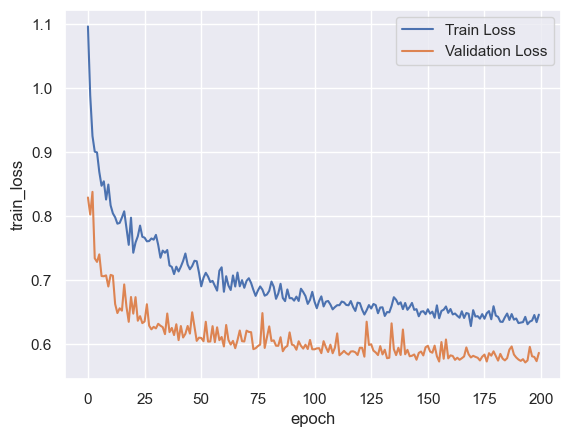

In [22]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=train_df, x="epoch", y="train_loss", label="Train Loss")
sns.lineplot(data=train_df, x="epoch", y="val_loss", label="Validation Loss")

for autoencoders it is always a good to make a visual verification, meaning taking a couple good and anomalous samples in order to verify that the autoencoder does what he is supposed to do.

In [39]:
import onnxruntime as ort
from matplotlib import pyplot as plt

from nerovision.nv_enums import ImageFormat
from nerovision.vision.io import NeroVisionIO
from nerovision.dl.auto_encoding.ad.AEAD import AnomalyDetectorAE
from nerovision.vision.preprocessing import VisionPreprocessing

In [27]:
im_paths_test = glob.glob(os.path.join(data_root_path, 'test', '**/**.png'), recursive=True)
anomalous_paths = list(filter(lambda p: 'good' not in p, im_paths_test))
good_paths = list(filter(lambda p: 'good' in p, im_paths_test))

In [28]:
ort_sess = ort.InferenceSession(model_path)
anomaly_detector = AnomalyDetectorAE(ort_sess)

In [37]:
def create_recon(im_path, model_session, im_h, im_w):
    im = NeroVisionIO.load_im_from_disk(im_path, image_format=ImageFormat.rgb)
    preprocessed = VisionPreprocessing.preprocess_image(im, im_h, im_w, ImageFormat.rgb)
    preprocessed = preprocessed.transpose((2, 0, 1))
    preprocessed = np.expand_dims(preprocessed, axis=0).astype(np.float32)
    outputs = model_session.run(None, {'input': preprocessed})
    recon = outputs[0][0]
    recon = np.transpose(recon, (1, 2, 0))
    latent_vector = outputs[1][0]
    recon = VisionPreprocessing.revert_rgb_normalization(recon)
    return recon, latent_vector
        

In [38]:
recon_good, _ = create_recon(good_paths[0], ort_sess, im_h, im_w)

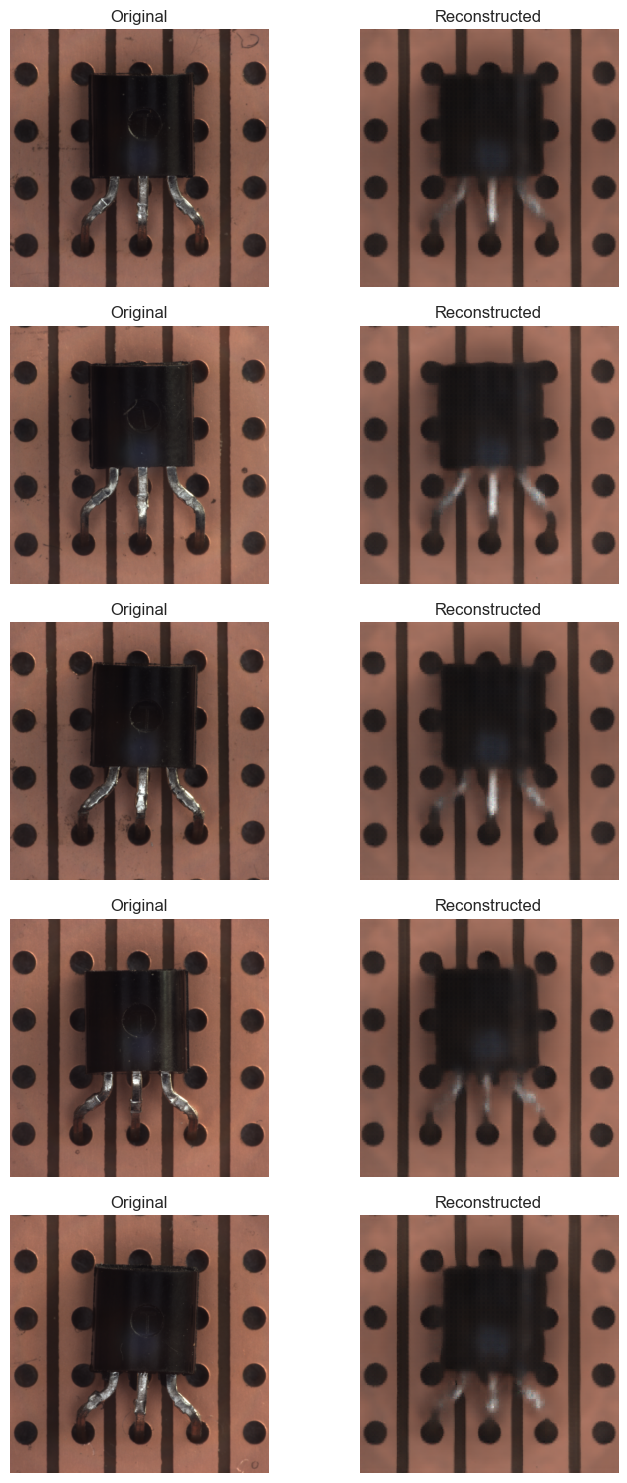

In [47]:
fig, axes = plt.subplots(5, 2, figsize=(8, 15))
columns = 2
rows = 5
aux = 1

for r in range(rows):
    random_good_im_path = np.random.choice(good_paths)
    origin_im = NeroVisionIO.load_im_from_disk(random_good_im_path, image_format=ImageFormat.rgb)
    recon_im, _ = create_recon(random_good_im_path, ort_sess, im_h, im_w)
    
    axes[r, 0].imshow(origin_im)
    axes[r, 0].axis("off")
    axes[r, 1].imshow(recon_im)
    axes[r, 1].axis("off")

    axes[r, 0].set_title("Original")
    axes[r, 1].set_title("Reconstructed")

plt.tight_layout()
plt.show()

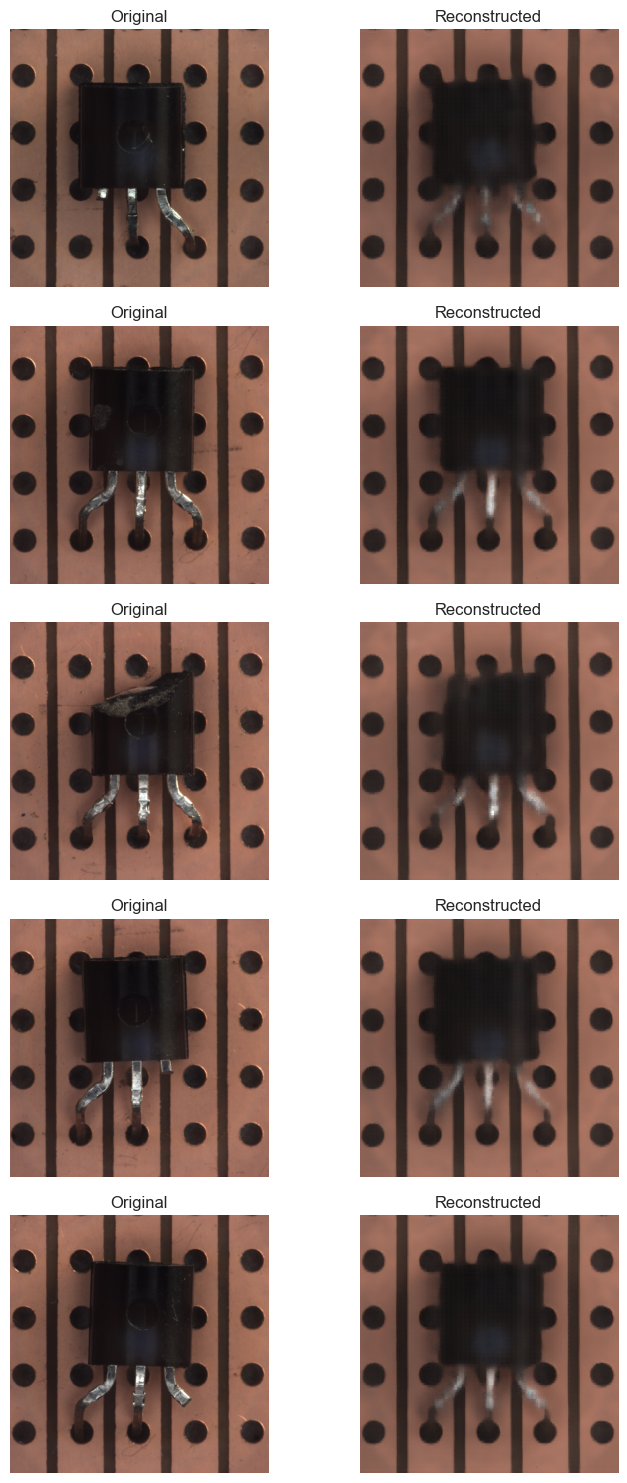

In [49]:
fig, axes = plt.subplots(5, 2, figsize=(8, 15))
columns = 2
rows = 5
aux = 1

for r in range(rows):
    random_anomaly_path = np.random.choice(anomalous_paths)
    origin_im = NeroVisionIO.load_im_from_disk(random_anomaly_path, image_format=ImageFormat.rgb)
    recon_im, _ = create_recon(random_anomaly_path, ort_sess, im_h, im_w)
    
    axes[r, 0].imshow(origin_im)
    axes[r, 0].axis("off")
    axes[r, 1].imshow(recon_im)
    axes[r, 1].axis("off")

    axes[r, 0].set_title("Original")
    axes[r, 1].set_title("Reconstructed")

plt.tight_layout()
plt.show()

The cells above show that the autoencoder works properly on the images, so we are good on that

# 2.0 Inference - Detect Anomalies

detect the anomalies on the transistor datasets to perform.
This section should demonstrate how we can use the current autoencoder to perform anomaly detection.

In [51]:
good_scores = []
anomalous_scores = []

for im_p in tqdm(good_paths):
    im = NeroVisionIO.load_im_from_disk(im_p, ImageFormat.rgb)
    anomaly_score = anomaly_detector.calculate_mse_anomaly_score(im, im_h, im_w, ImageFormat.rgb)
    good_scores.append(anomaly_score)

for im_p in tqdm(anomalous_paths):
    im = NeroVisionIO.load_im_from_disk(im_p, ImageFormat.rgb)
    anomaly_score = anomaly_detector.calculate_mse_anomaly_score(im, im_h, im_w, ImageFormat.rgb)
    anomalous_scores.append(anomaly_score)


100%|██████████| 40/40 [00:02<00:00, 13.94it/s]


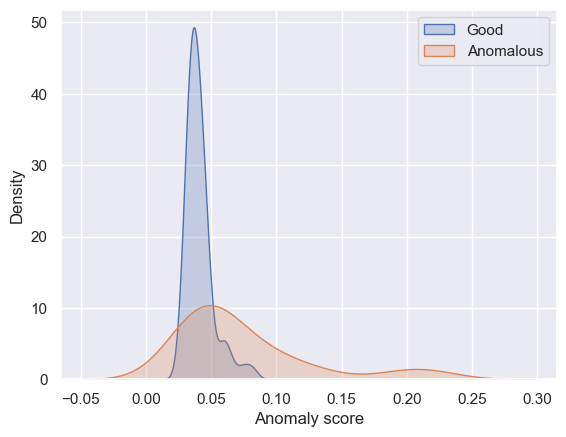

In [52]:
sns.set_style("darkgrid")
sns.kdeplot(good_scores, label="Good", fill=True)
sns.kdeplot(anomalous_scores, label="Anomalous", fill=True)
plt.xlabel("Anomaly score")
plt.legend()